In [1]:
import numpy as np
import pandas as pd
import os
import glob2
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [2]:
# Importing the DataFrame with image name and label
df = pd.read_csv(r'C:\Users\stple\Documents\chest_xray\Data_Entry_2017.csv')

# Importing the file path to each image on my PC
image_paths = {os.path.basename(x): x for x in 
                   glob2.glob(r'C:\Users\stple\Documents\chest_xray\images\*.png')}

In [3]:
# Appending file path to the DataFrame
df['filepath'] = df['Image Index'].map(image_paths.get)
df = df[~df['filepath'].isna()]

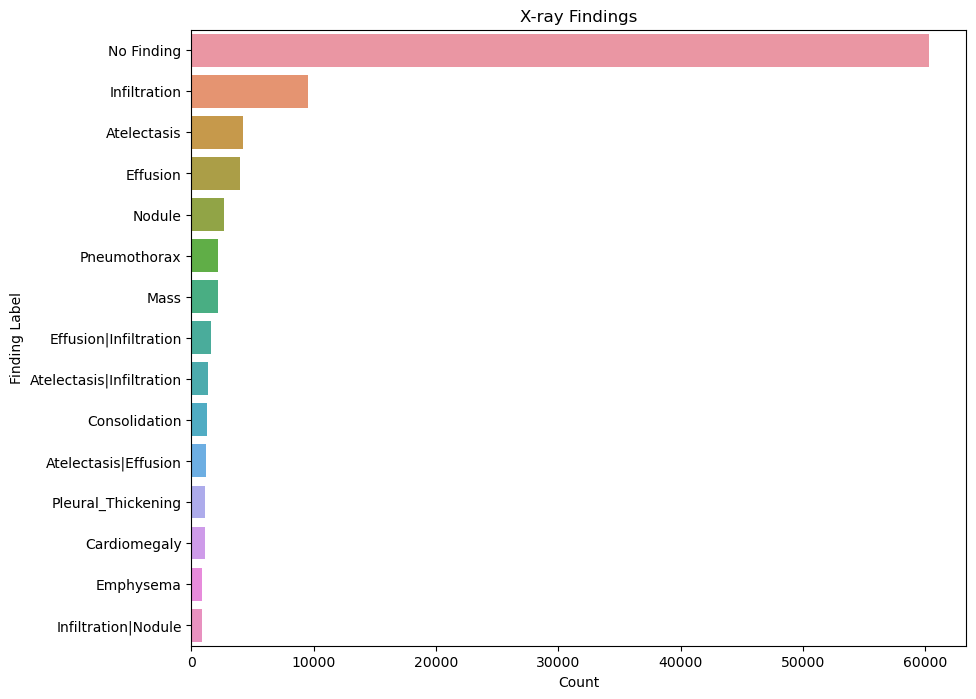

In [4]:
# Plotting only top 15 labels
top_labels = df['Finding Labels'].value_counts().nlargest(15)

plt.figure(figsize=(10, 8))
sns.countplot(data=df[df['Finding Labels'].isin(top_labels.index)], y='Finding Labels', order=top_labels.index)
plt.xlabel('Count')
plt.ylabel('Finding Label')
plt.title('X-ray Findings')

plt.show()

In [5]:
# Creating a set of all the labels in the data
unique_labels = set()
for labels in df['Finding Labels']:
    for label in labels.split('|'):
        unique_labels.add(label)

### Correcting Bias to Improve Training
The model has significantly more examples of No Findings, so we are going to weight each record by its number of findings and take a new sample of the data according to these weights. This will help improve the training of the model by reducing class imbalance.

In [6]:
from math import floor

# Choosing a subset of the data, weighted by how many findings each row has
adj_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if x != 'No Finding' else 0).values + 0.05
adj_weights /= adj_weights.sum()

df_adj = df.sample(floor(df.shape[0]/1.8), weights = adj_weights)

### Plotting Distribution with New Weights

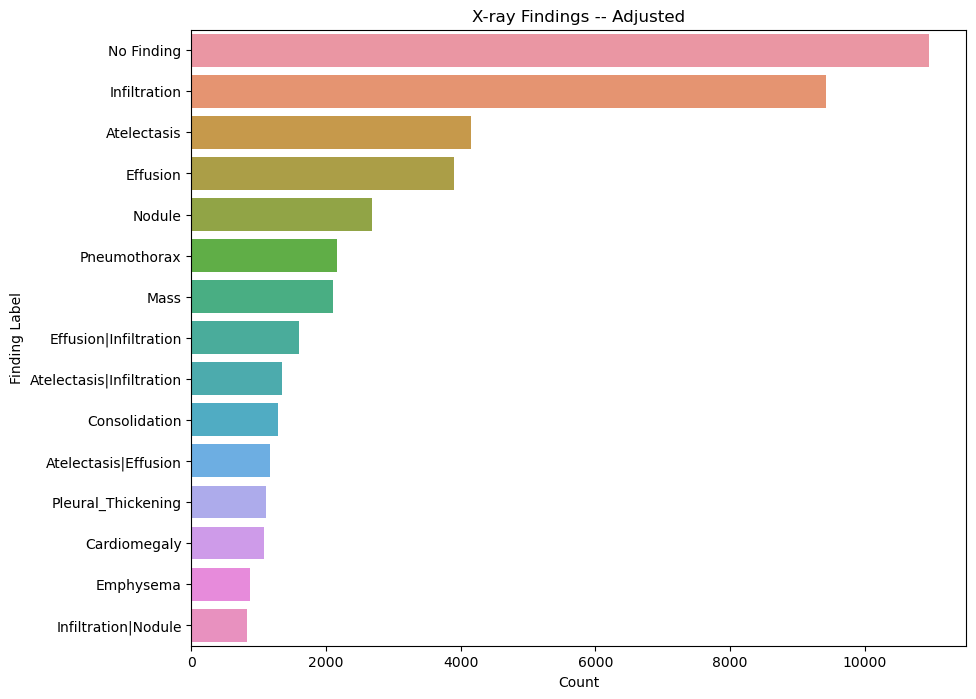

In [7]:
# Plotting top findings after re-weighting
top_labels = df_adj['Finding Labels'].value_counts().nlargest(15)

plt.figure(figsize=(10, 8))
sns.countplot(data=df_adj[df_adj['Finding Labels'].isin(top_labels.index)], y='Finding Labels', order=top_labels.index)
plt.xlabel('Count')
plt.ylabel('Finding Label')
plt.title('X-ray Findings -- Adjusted')

plt.show()

In [8]:
# Transforming | separated values to a list
df_adj['Labels'] = df_adj.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Train Test Split

This is used to separate the data into a training and testing group so that you make sure to test the model on data that hasn't yet been seen.

I also separate the df_temp into two datasets, one for actual testing, and one for validation during the training, which the model will use to evaluate after each epoch.

In [10]:
df_train, df_temp = train_test_split(df_adj, 
                                   test_size = 0.15, 
                                   random_state = 391,
                                   stratify = df_adj['Finding Labels'].map(lambda x: x[:5]))

df_test = df_temp.iloc[:df_temp.shape[0]//2,:]
df_validate = df_temp.iloc[df_temp.shape[0]//2:,:]

### ImageDataGenerator

This is a very important pre-processing step where we randomly alter the images in small ways to decrease overfitting in the model, and then we normalize the data so that the input stays in a consistent range.

The flow_from_dataframe() function helps with some of these preprocessing steps and only loads and preprocesses batches of the images at a time. This improves performance and memory usage during training.

In [12]:
data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=5,  # Randomly rotate images
    shear_range=0.08,  # Randomly shear images
    samplewise_center=True,  # Center the images sample-wise
    samplewise_std_normalization=True,  # Normalize images sample-wise
)

data_train = data_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',  
    y_col='Labels',  
    class_mode='categorical',  
    classes = unique_labels,
    color_mode='grayscale',  
    target_size=(256, 256),  # Resize images to 256x256
    batch_size=32  
)

data_validate = data_gen.flow_from_dataframe(
    dataframe=df_validate,
    x_col='filepath',  
    y_col='Labels',  
    class_mode='categorical',  
    classes = unique_labels,
    color_mode='grayscale',  
    target_size=(256, 256),  # Resize images to 256x256
    batch_size=128 
)

data_test_x, data_test_y = next(data_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',  
    y_col='Labels',  
    class_mode='categorical',  
    classes = unique_labels,
    color_mode='grayscale', 
    target_size=(256, 256),  # Resize images to 256x256
    batch_size=2056
))

Found 52944 validated image filenames belonging to 15 classes.
Found 4672 validated image filenames belonging to 15 classes.
Found 4672 validated image filenames belonging to 15 classes.


### Plotting some examples from the test data

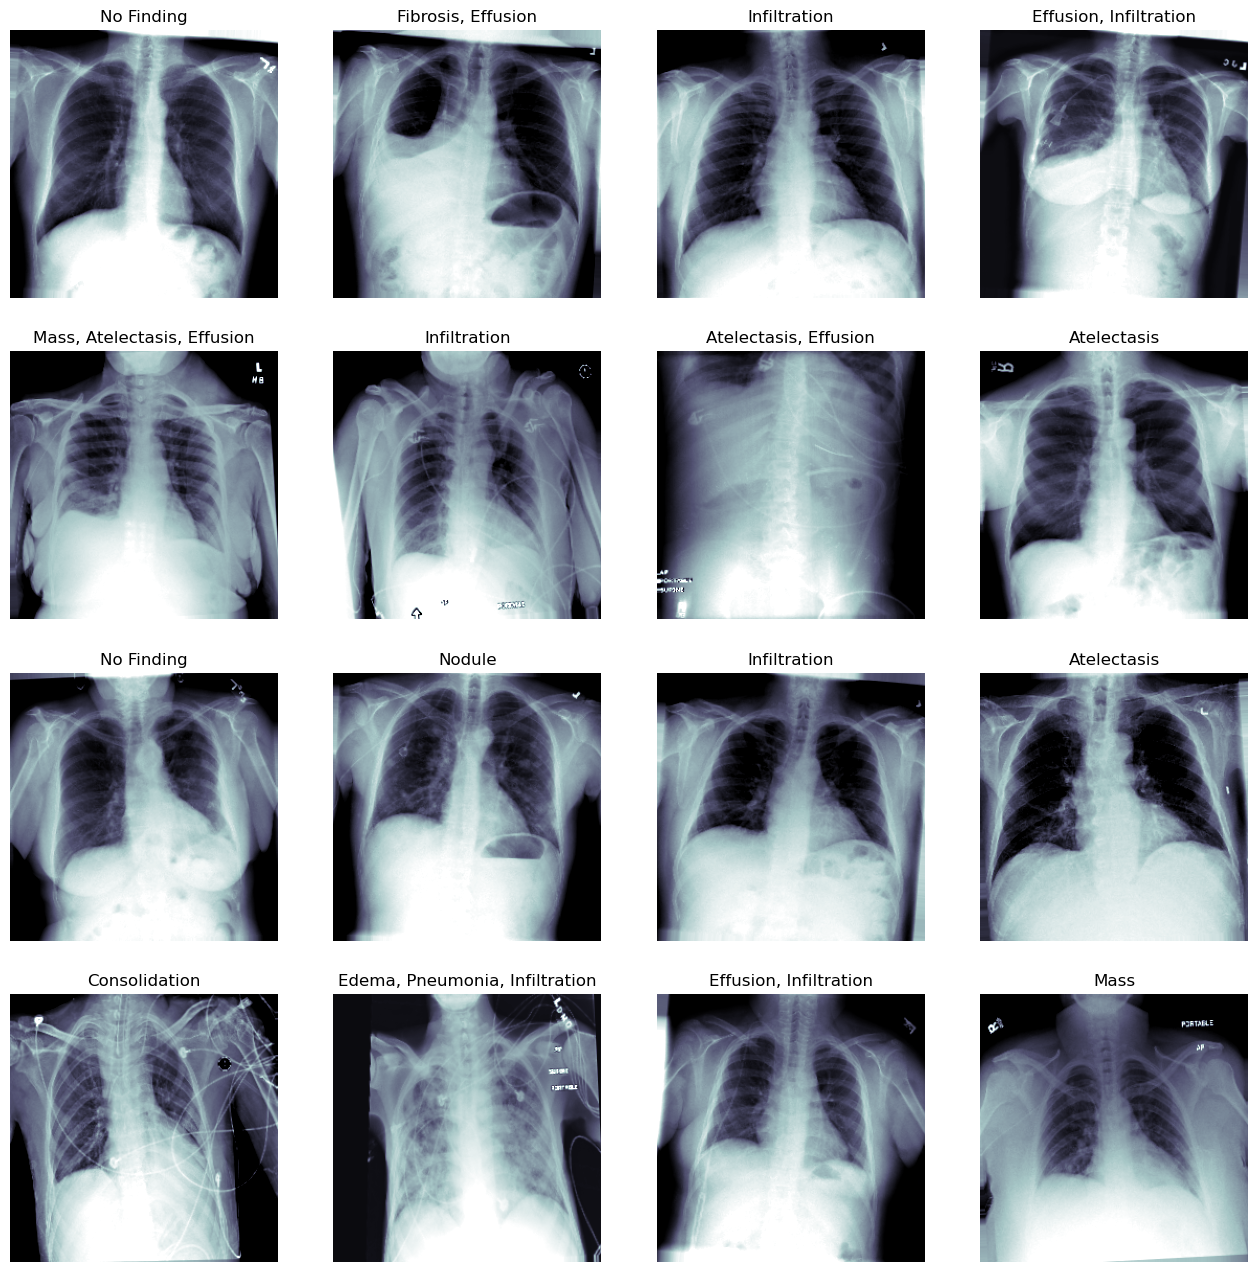

In [13]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(data_test_x, data_test_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(unique_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

### Create Convolutional Neural Network Model

We begin with a MobileNet model which is a convolutional neural network and then add some additional layers on top of it to handle flattening and processing of the data.

The sigmoid activation function here is particularly important because this will output a value between 0 and 1 which we can then interpret however we want to the original labels. A typical approach might be to round values below 0.5 to 0 and above 0.5 to 1 to evaluate model performance.

In [15]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenetmodel = MobileNet(input_shape =  data_test_x.shape[1:], 
                                 include_top = False, weights = None)

model = Sequential()
model.add(mobilenetmodel)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_256 (Functio  (None, 8, 8, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                7

### Training the Model

In [17]:
model.fit(data_train, 
                      steps_per_epoch=100,
                      validation_data = data_validate, 
                      epochs = 10)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3253 - binary_accuracy: 0.8897 - mae: 0.1620
Epoch 1: val_loss improved from inf to 0.28776, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 281s 3s/step - loss: 0.3253 - binary_accuracy: 0.8897 - mae: 0.1620 - val_loss: 0.2878 - val_binary_accuracy: 0.9023 - val_mae: 0.1636
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2930 - binary_accuracy: 0.8985 - mae: 0.1633
Epoch 2: val_loss did not improve from 0.28776
100/100 [==============================] - 249s 2s/step - loss: 0.2930 - binary_accuracy: 0.8985 - mae: 0.1633 - val_loss: 0.3242 - val_binary_accuracy: 0.9023 - val_mae: 0.1269
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2891 - binary_accuracy: 0.8985 - mae: 0.1638
Epoch 3: val_loss did not improve from 0.28776
100/100 [==============================] - 249s 2s/step - loss: 0.2891 - binary_accuracy: 0.8985 - mae: 0.